RBF

In [177]:
from filtrar_datos import filtrar_datos_en_rango
from procesar_tableros import procesar_tableros
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import os
import numpy as np
import scipy
import scipy.io
from procesar_tableros import *
from filtrar_datos import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import xlsxwriter
class RBFNetwork:
    def __init__(self, num_centers, sigma, lambda_reg):
        self.num_centers = num_centers
        self.sigma = sigma
        self.lambda_reg = lambda_reg
        self.centers = None
        self.weights = None

    def _calculate_activations(self, X):
        #distances = scipy.spatial.distance.cdist(X, self.centers)
        distances = np.linalg.norm(X[:, None, :] - self.centers[None, :, :], axis=2)
        activations = np.exp(-distances**2 / (2 * self.sigma**2))
        return activations

    def fit(self, X, y):
        indices = np.random.choice(X.shape[0], self.num_centers, replace=False)
        self.centers = X[indices]
        activations = self._calculate_activations(X)
        
        regularization_matrix = self.lambda_reg * np.eye(activations.shape[1])
        self.weights = np.linalg.solve(activations.T @ activations + regularization_matrix, activations.T @ y)


    def predict(self, X):
        activations = self._calculate_activations(X)
        return activations @ self.weights


Cargar datos

In [178]:
# Cargar datos
print("Cargando datos...")
file_path_1bit = "./10x10/10x10/1bit/DATASET_v7.mat"
file_path_2bit = "./10x10/10x10/2bit/DATASET_v7.mat"

mat_data1b = scipy.io.loadmat(file_path_1bit)
mat_data2b = scipy.io.loadmat(file_path_2bit)
print("Datos cargados.")

# Obtenemos los dataset
dataset1b = mat_data1b['DATASET']
dataset2b = mat_data2b['DATASET']

# Acceder a las variables dentro del archivo (1bit)
labels_1b = dataset1b['labels']
inputs_1b = dataset1b['input']
bits_1b = dataset1b['bits']
beams_1b = dataset1b['beams']

# Acceder a las variables dentro del archivo (2bit)
labels_2b = dataset2b['labels']
inputs_2b = dataset2b['input']
bits_2b = dataset2b['bits']
beams_2b = dataset2b['beams']

Cargando datos...
Datos cargados.


In [179]:

# Acceder a las variables dentro del archivo (1bit)
labels_1b = dataset1b['labels']
inputs_1b = dataset1b['input']
bits_1b = dataset1b['bits']
beams_1b = dataset1b['beams']

# Acceder a las variables dentro del archivo (2bit)
labels_2b = dataset2b['labels']
inputs_2b = dataset2b['input']
bits_2b = dataset2b['bits']
beams_2b = dataset2b['beams']

Filtrar datos y procesar tableros

In [180]:
# Filtrar datos de 1 bit
print("Filtrando datos de 1 bit...")
datos1b_filtrados_input, datos1b_filtrados_labels = filtrar_datos_en_rango(inputs_1b, labels_1b)

# Filtrar datos de 2 bits
print("Filtrando datos de 2 bits...")
datos2b_filtrados_input, datos2b_filtrados_labels = filtrar_datos_en_rango(inputs_2b, labels_2b)

print("Datos filtrados listos.")

# Procesar los tableros
print("Procesando tableros...")

# 1 bit
tableros_procesados_1b = procesar_tableros(datos1b_filtrados_labels, 1)

# 2 bit
tableros_procesados_2b = procesar_tableros(datos2b_filtrados_labels, 2)

# Verificar dimensiones antes de transponer
print("Dimensiones antes de reshaping:")
print("tableros_procesados_1b.shape:", tableros_procesados_1b.shape)
print("tableros_procesados_2b.shape:", tableros_procesados_2b.shape)

# Reshape tableros
rs_tableros_procesados_1b = tableros_procesados_1b.reshape(-1, tableros_procesados_1b.shape[1] * tableros_procesados_1b.shape[2])
rs_tableros_procesados_2b = tableros_procesados_2b.reshape(-1, tableros_procesados_2b.shape[1] * tableros_procesados_2b.shape[2])

print("Dimensiones después de reshaping:")
print("rs_tableros_procesados_1b.shape:", rs_tableros_procesados_1b.shape)
print("rs_tableros_procesados_2b.shape:", rs_tableros_procesados_2b.shape)

# Ajustar las dimensiones de datos1b_filtrados_labels
reshaped_labels_1b = datos1b_filtrados_labels.reshape(-1, datos1b_filtrados_labels.shape[0] * datos1b_filtrados_labels.shape[1])
reshaped_labels_2b = datos2b_filtrados_labels.reshape(-1, datos2b_filtrados_labels.shape[0] * datos2b_filtrados_labels.shape[1])

# Comprobar las dimensiones después del reshaping
print("Dimensiones de reshaped_labels_1b:", reshaped_labels_1b.shape)
print("Dimensiones de reshaped_labels_2b:", reshaped_labels_2b.shape)

# Comprobar las dimensiones de datos1b
print("Dimensiones de datos1b_filtrados_labels:", datos1b_filtrados_labels.shape)
print("Dimensiones de datos2b_filtrados_labels:", datos2b_filtrados_labels.shape)

# Comprobar las dimensiones de datos1b
print("Dimensiones de datos1b_filtrados_inputs:", datos1b_filtrados_input.shape)
print("Dimensiones de datos2b_filtrados_inputs:", datos2b_filtrados_input.shape)



Filtrando datos de 1 bit...
Filtrando datos de 2 bits...
Datos filtrados listos.
Procesando tableros...
Dimensiones antes de reshaping:
tableros_procesados_1b.shape: (9180, 10, 10)
tableros_procesados_2b.shape: (9180, 10, 10)
Dimensiones después de reshaping:
rs_tableros_procesados_1b.shape: (9180, 100)
rs_tableros_procesados_2b.shape: (9180, 100)
Dimensiones de reshaped_labels_1b: (9180, 100)
Dimensiones de reshaped_labels_2b: (9180, 100)
Dimensiones de datos1b_filtrados_labels: (10, 10, 9180)
Dimensiones de datos2b_filtrados_labels: (10, 10, 9180)
Dimensiones de datos1b_filtrados_inputs: (9180, 2)
Dimensiones de datos2b_filtrados_inputs: (9180, 2)


Pruebas

In [181]:
# Inicializar matrices para almacenar métricas
predicciones_100_RBFs = np.zeros((10, 10, rs_tableros_procesados_1b.shape[0]))
mse_metrics = np.zeros((10, 10))
mae_metrics = np.zeros((10, 10))
r2_metrics = np.zeros((10, 10))

print(f"rs_tableros_procesados_1b:  ", rs_tableros_procesados_1b.shape)
print(f"datos1b_filtrados_input:  ", datos1b_filtrados_input.shape)

# Definir valores de alpha y sigma para las pruebas
lambda_regs = [0.01, 1, 10, 100]
alpha_factors = [0.01, 0.1, 1]

# Inicializar la matriz multidimensional para almacenar las métricas
# Dimensiones: (10 celdas, 10 celdas, len(Alpha), len(Sigma), len(Lambda))
mse_metrics_matrix_all = np.zeros((10, 10, 6, 6, len(lambda_regs)))
mae_metrics_matrix_all = np.zeros((10, 10, 6, 6, len(lambda_regs)))
r2_metrics_matrix_all = np.zeros((10, 10, 6, 6, len(lambda_regs)))

# Definir valores de alpha, sigma y lambda_reg para las pruebas
alphas_up = []
sigmas_up = []
lambda_up = []

# Realizar pruebas variando num_centers y sigma
for i in range(10):
    for j in range(10):
        y_labels = rs_tableros_procesados_1b[:, i * 10 + j].reshape(-1, 1)
        print(f"Y_labels: ", y_labels.shape)
        X_train1, X_test1, y_train1, y_test1 = train_test_split(
            datos1b_filtrados_input, y_labels, test_size=0.4, random_state=42
        )
        print(f"Datos divididos para la celda ({i},{j}).")

        nc1 = len(X_train1) // 10   # LINEAS NUEVAS 27_6
        #nc1 = 2000 # 2000
        print(f"nc1: ", nc1)
        #alphas = np.linspace(nc1 / len(X_train1) / 2, nc1 / len(X_train1) * 2, 10)  #LINEAS NUEVAS 27_6
        alphas = [1, 10, 100, 1000, 3000, len(X_train1)]
        #alphas = np.logspace(np.log10(nc1 / 100), np.log10(nc1 * 10), 10)
        #alphas = [nc1 * factor for factor in alpha_factors]
        print(f"alphas: ", alphas)

        dc = np.linalg.norm(X_train1[:, None] - X_train1[None, :], axis=-1)
        sg = np.median(dc)
        #sg = 7.5 # 15
        print(f"sg: ", sg)
        #sigmas = np.linspace(sg / 4, sg * 4, 10)
        #sigmas = np.logspace(np.log10(sg / 100), np.log10(sg* 100), 10)
        #sigmas = [sg * factor for factor in alpha_factors]
        sigmas = [1, 2, 4, 8, 16, 32]
        print(f"sigmas: ", sigmas)

        # Inicializar matriz para almacenar resultados
        results = np.zeros((len(alphas), len(sigmas), len(lambda_regs)))

        for alpha_index, alpha in enumerate(alphas):
            #num_centers = int(np.ceil(len(X_train1) * alpha))
            num_centers = alpha
            for sigma_index, sigma in enumerate(sigmas):
                for lambda_reg_index, lambda_reg in enumerate(lambda_regs):
                    print(f"Probando con num_centers = {num_centers} y sigma = {sigma}...")
                    rbf_net = RBFNetwork(num_centers=num_centers, sigma=sigma, lambda_reg=lambda_reg)
                    rbf_net.fit(X_train1, y_train1)
                    predictions_test = rbf_net.predict(X_test1)
                    mse_test = mean_squared_error(y_test1, predictions_test)
                    results[alpha_index, sigma_index, lambda_reg_index] = mse_test
                    print(f"MSE en conjunto de prueba con num_centers = {num_centers} y sigma = {sigma} y lambda_reg = {lambda_reg}: {mse_test}")

                    # Almacenar las métricas en la matriz multidimensional
                    mse_metrics_matrix_all[i, j, alpha_index, sigma_index, lambda_reg_index] = mse_test
                    mae_metrics_matrix_all[i, j, alpha_index, sigma_index, lambda_reg_index] = mean_absolute_error(y_test1, predictions_test)
                    r2_metrics_matrix_all[i, j, alpha_index, sigma_index, lambda_reg_index] = r2_score(y_test1, predictions_test)


        # Almacenar los resultados de la mejor configuración en las matrices de métricas
        best_alpha_index, best_sigma_index, best_lambda_reg_index = np.unravel_index(np.argmin(results), results.shape)
        #best_num_centers = int(np.ceil(len(X_train1) * alphas[best_alpha_index]))
        best_num_centers = alphas[best_alpha_index]
        best_sigma = sigmas[best_sigma_index]
        best_lambda_reg = lambda_regs[best_lambda_reg_index]
        print(f"Best alpha: ", best_num_centers)
        print(f"Best sigma: ", best_sigma)
        print(f"Best lamda_reg: ", best_lambda_reg)
        # Añadir
        alphas_up.append(best_num_centers)
        sigmas_up.append(best_sigma)
        lambda_up.append(best_lambda_reg)


        # Entrenar la RBF con los mejores hiperparámetros
        rbf_net = RBFNetwork(num_centers=best_num_centers, sigma=best_sigma, lambda_reg=best_lambda_reg)
        rbf_net.fit(X_train1, y_train1)
        predictions_all = rbf_net.predict(X_test1)

        # Almacenar las predicciones y métricas
        predicciones_100_RBFs[i, j, :len(predictions_all)] = predictions_all.flatten()
        mse_metrics[i, j] = mean_squared_error(y_test1, predictions_all)
        mae_metrics[i, j] = mean_absolute_error(y_test1, predictions_all)
        r2_metrics[i, j] = r2_score(y_test1, predictions_all)




rs_tableros_procesados_1b:   (9180, 100)
datos1b_filtrados_input:   (9180, 2)
Y_labels:  (9180, 1)
Datos divididos para la celda (0,0).
nc1:  550
alphas:  [1, 10, 100, 1000, 3000, 5508]
sg:  56.85068161420758
sigmas:  [1, 2, 4, 8, 16, 32]
Probando con num_centers = 1 y sigma = 1...
MSE en conjunto de prueba con num_centers = 1 y sigma = 1 y lambda_reg = 0.01: 0.01720037799141049
Probando con num_centers = 1 y sigma = 1...
MSE en conjunto de prueba con num_centers = 1 y sigma = 1 y lambda_reg = 1: 0.017163930198592338
Probando con num_centers = 1 y sigma = 1...
MSE en conjunto de prueba con num_centers = 1 y sigma = 1 y lambda_reg = 10: 0.01715686274509804
Probando con num_centers = 1 y sigma = 1...
MSE en conjunto de prueba con num_centers = 1 y sigma = 1 y lambda_reg = 100: 0.017156862745150908
Probando con num_centers = 1 y sigma = 2...
MSE en conjunto de prueba con num_centers = 1 y sigma = 2 y lambda_reg = 0.01: 0.0171568627450983
Probando con num_centers = 1 y sigma = 2...
MSE en 

Guardar datos

In [182]:
# Display results
print("Resultados de las métricas para la celda (0,0):")
print(f"Celda (0,0): MSE={mse_metrics[0, 0]}, MAE={mae_metrics[0, 0]}, R2={r2_metrics[0, 0]}")

# Display results
print("Resultados de las métricas para la celda (0,1):")
print(f"Celda (0,1): MSE={mse_metrics[0, 1]}, MAE={mae_metrics[0, 1]}, R2={r2_metrics[0, 1]}")

# Display results
print("Resultados de las métricas para la celda (0,2):")
print(f"Celda (0,2): MSE={mse_metrics[0, 2]}, MAE={mae_metrics[0, 2]}, R2={r2_metrics[0, 2]}")

print(f"mse_metrics: ", mse_metrics)
print(f"mae_metrics: ", mae_metrics)
print(f"r2_metrics: ", r2_metrics)

print(f"predictions: ", predicciones_100_RBFs)

Resultados de las métricas para la celda (0,0):
Celda (0,0): MSE=0.015317605834625303, MAE=0.039307966759179344, R2=0.09161740731917833
Resultados de las métricas para la celda (0,1):
Celda (0,1): MSE=0.12550143726923624, MAE=0.2576747080495453, R2=0.24125435303833898
Resultados de las métricas para la celda (0,2):
Celda (0,2): MSE=0.12338909193650854, MAE=0.2535864420136543, R2=0.4583669541168628
mse_metrics:  [[0.01531761 0.12550144 0.12338909 0.14063117 0.13305908 0.13958979
  0.1467954  0.14775038 0.1469687  0.15034796]
 [0.12611238 0.13576589 0.13236251 0.13939128 0.13943457 0.14769773
  0.14336008 0.14611586 0.15311694 0.15776621]
 [0.12527776 0.13098247 0.13879626 0.1333973  0.14104529 0.14632168
  0.14842866 0.14286125 0.1455527  0.15192578]
 [0.14164601 0.13517801 0.13922426 0.14827555 0.14232394 0.14384388
  0.14559873 0.14501184 0.15461306 0.15918009]
 [0.13978435 0.14432741 0.13656241 0.14436078 0.14480712 0.13992788
  0.14501051 0.14666238 0.15257631 0.15228246]
 [0.142135

Guardar datos (all)

Resultados de las métricas:
Celda (0,0): MSE=0.015317605834625303, MAE=0.039307966759179344, R2=0.09161740731917833
Celda (0,1): MSE=0.12550143726923624, MAE=0.2576747080495453, R2=0.24125435303833898
Celda (0,2): MSE=0.12338909193650854, MAE=0.2535864420136543, R2=0.4583669541168628
Celda (0,3): MSE=0.14063116526725405, MAE=0.2817820755926831, R2=0.4043450523609131
Celda (0,4): MSE=0.1330590789806866, MAE=0.2699693679118501, R2=0.42871658859023476
Celda (0,5): MSE=0.1395897939295248, MAE=0.2900174643096292, R2=0.42704907662160163
Celda (0,6): MSE=0.14679540346403977, MAE=0.2982113892216628, R2=0.4036213815186206
Celda (0,7): MSE=0.14775038284523723, MAE=0.2943592603012166, R2=0.3981049207643903
Celda (0,8): MSE=0.14696869950437144, MAE=0.30147804600097744, R2=0.3969765200578933
Celda (0,9): MSE=0.15034796483275403, MAE=0.30136530374837367, R2=0.38850464133340823
Celda (1,0): MSE=0.12611238309047143, MAE=0.2592561456881259, R2=0.20741602526627245
Celda (1,1): MSE=0.1357658912391416, MA

c:\Users\ismae\OneDrive\Cosas inutiles\Escritorio\master\TFM\cupy-env\Lib\site-packages\pandas\plotting\_matplotlib\tools.py:233: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(**fig_kw)


Gráficos guardados en hyperparam_optimization_results_boxplot.pdf
Celda: 0, Alpha: 1, Valores: 0.017156854013030142
Celda: 0, Alpha: 10, Valores: 0.01661911608946834
Celda: 0, Alpha: 100, Valores: 0.0159970814841206
Celda: 0, Alpha: 1000, Valores: 0.015394828380671783
Celda: 0, Alpha: 3000, Valores: 0.015341418154192689
Celda: 0, Alpha: 5508, Valores: 0.015317605834625252
Celda: 1, Alpha: 1, Valores: 0.20790092925880493
Celda: 1, Alpha: 10, Valores: 0.16420721191101156
Celda: 1, Alpha: 100, Valores: 0.12628971935014324
Celda: 1, Alpha: 1000, Valores: 0.12553576704036323
Celda: 1, Alpha: 3000, Valores: 0.12550605736543902
Celda: 1, Alpha: 5508, Valores: 0.12550610514731164
Celda: 2, Alpha: 1, Valores: 0.34047311792289725
Celda: 2, Alpha: 10, Valores: 0.3235864603011646
Celda: 2, Alpha: 100, Valores: 0.12892682604606934
Celda: 2, Alpha: 1000, Valores: 0.12348982346848619
Celda: 2, Alpha: 3000, Valores: 0.12343065437389573
Celda: 2, Alpha: 5508, Valores: 0.12338909193650857
Celda: 3, Alph

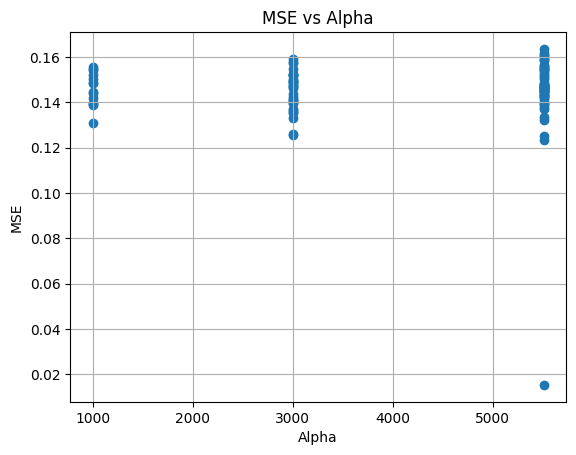

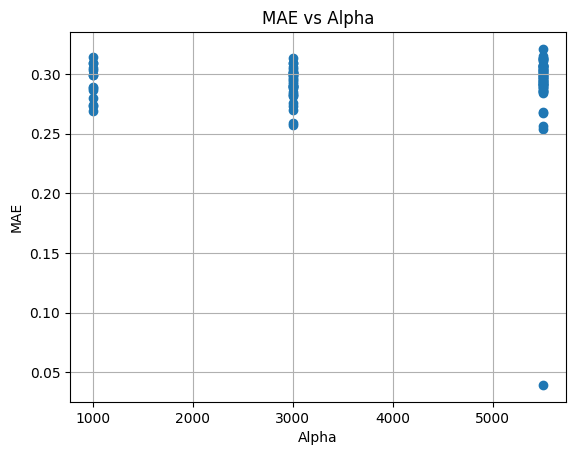

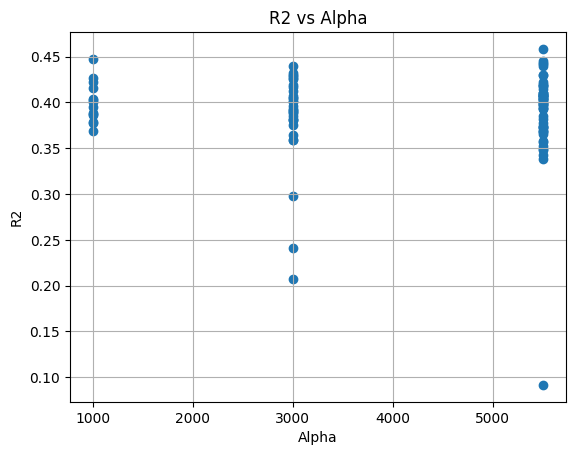

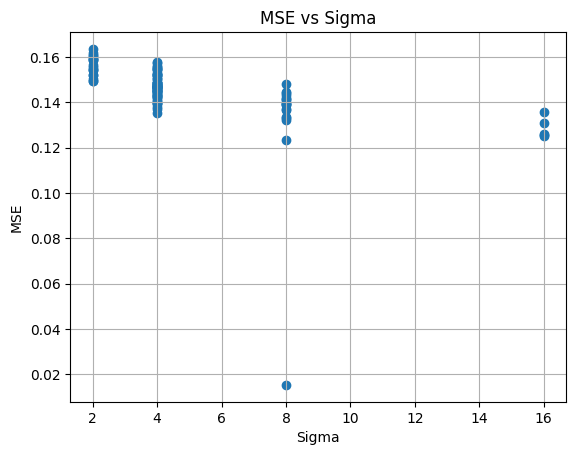

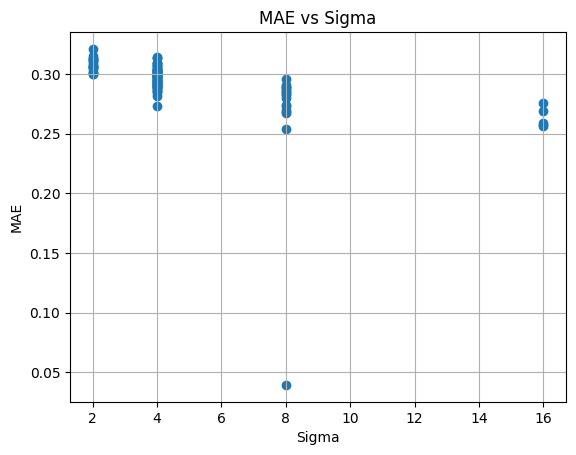

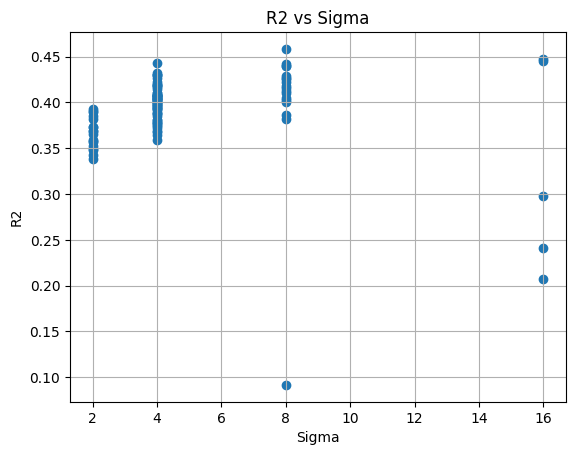

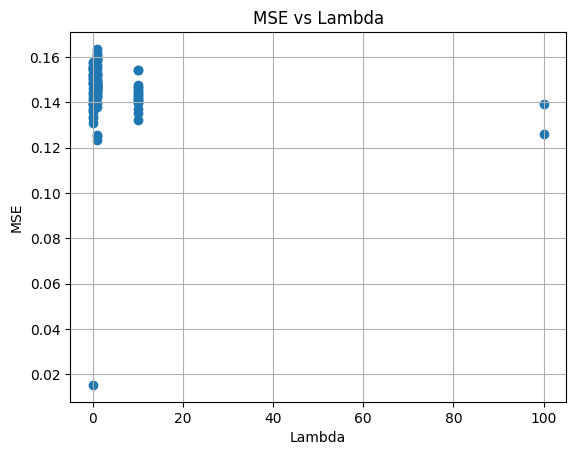

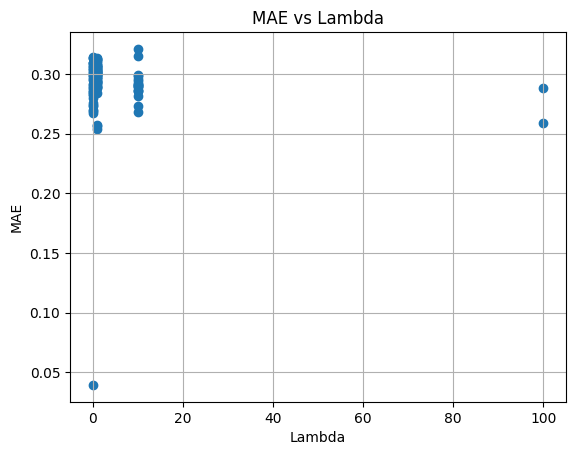

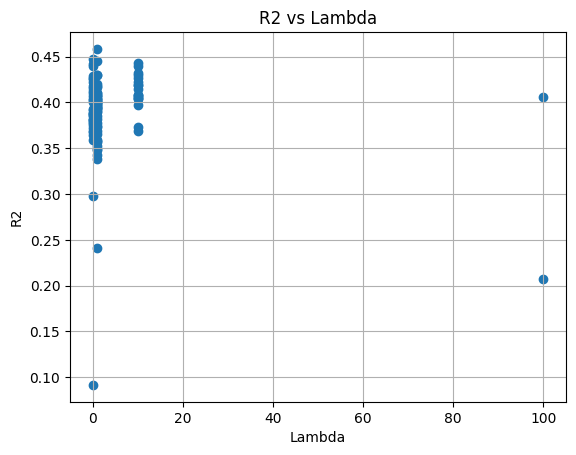

<Figure size 640x480 with 0 Axes>

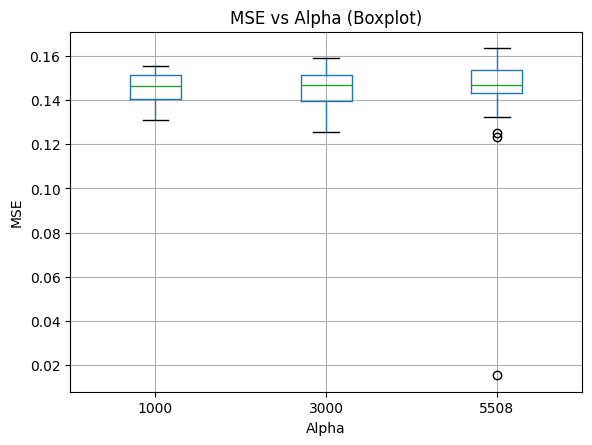

<Figure size 640x480 with 0 Axes>

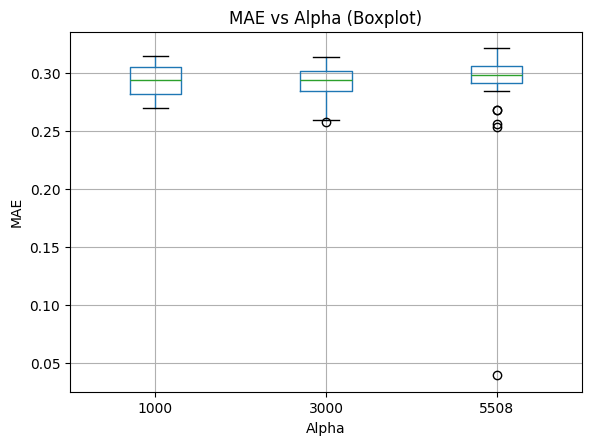

<Figure size 640x480 with 0 Axes>

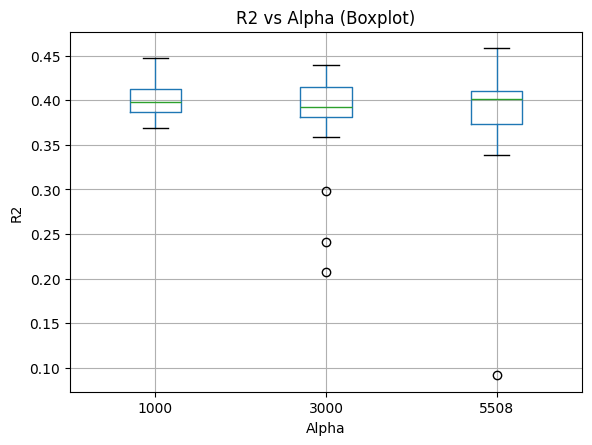

<Figure size 640x480 with 0 Axes>

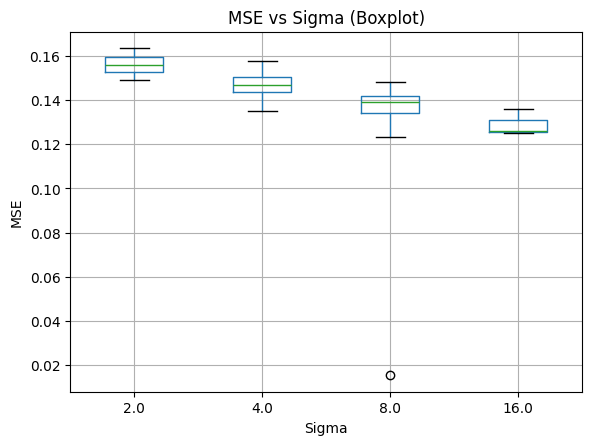

<Figure size 640x480 with 0 Axes>

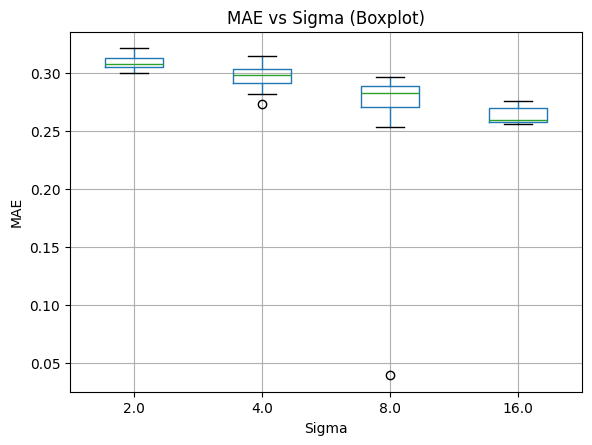

<Figure size 640x480 with 0 Axes>

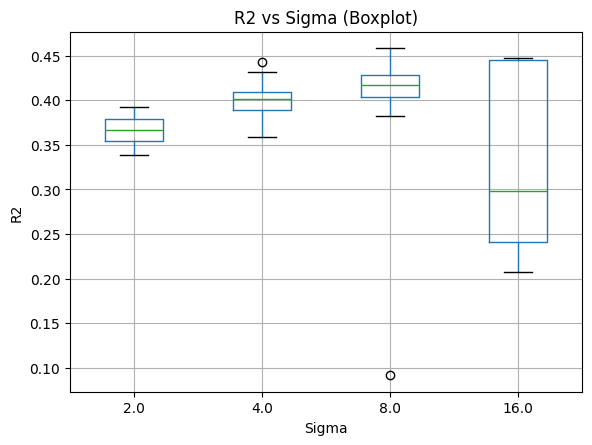

<Figure size 640x480 with 0 Axes>

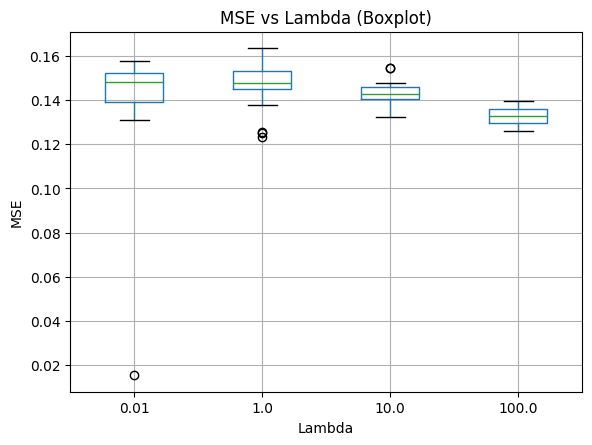

<Figure size 640x480 with 0 Axes>

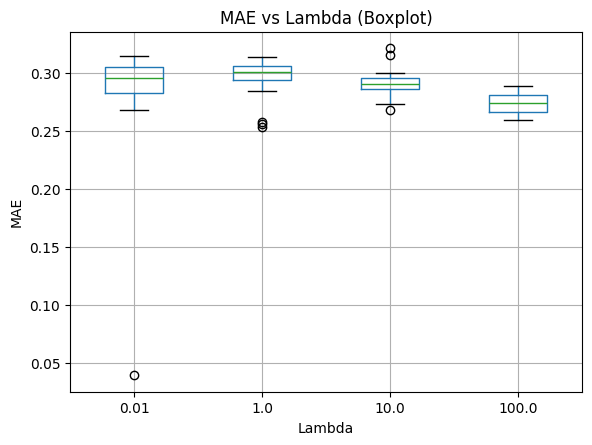

<Figure size 640x480 with 0 Axes>

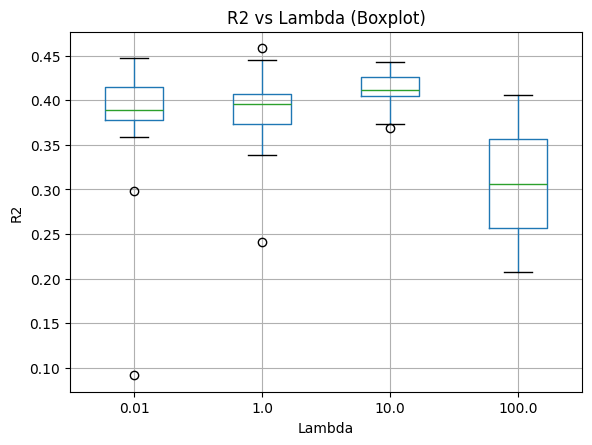

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

In [186]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xlsxwriter
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_metric_vs_hyperparam(metric_values, hyperparam_values, hyperparam_name, metric_name):
    plt.figure()
    plt.scatter(hyperparam_values, metric_values)
    plt.xlabel(hyperparam_name)
    plt.ylabel(metric_name)
    plt.title(f'{metric_name} vs {hyperparam_name}')
    plt.grid(True)
    return plt.gcf()

def plot_boxplot_metric_vs_hyperparam(metric_values, hyperparam_values, hyperparam_name, metric_name):
    plt.figure()
    df = pd.DataFrame({hyperparam_name: hyperparam_values, metric_name: metric_values})
    df.boxplot(column=metric_name, by=hyperparam_name)
    plt.title(f'{metric_name} vs {hyperparam_name} (Boxplot)')
    plt.suptitle("")  # Elimina el título redundante generado por boxplot
    plt.xlabel(hyperparam_name)
    plt.ylabel(metric_name)
    plt.grid(True)
    return plt.gcf()

def plot_boxplot_mse_vs_hyperparam(fixed_param1, fixed_param2, hyperparam_values, mse_values, hyperparam_name, metric_name, pdf):

    # Crear un DataFrame para el boxplot
    df = pd.DataFrame({hyperparam_name: hyperparam_values, metric_name: mse_values})

    plt.figure(figsize=(10, 6))
    df.boxplot(column=metric_name, by=hyperparam_name)
    plt.title(f'{metric_name} vs {hyperparam_name}\n(Fijos: {fixed_param1}, {fixed_param2})')
    plt.suptitle("")  # Eliminar título redundante generado por boxplot
    plt.xlabel(hyperparam_name)
    plt.ylabel(metric_name)
    plt.grid(True)

    # Guardar en el PDF
    pdf.savefig()
    plt.close()

import seaborn as sns

##ALPHAS
def plot_boxplot_mean_mse_vs_hyperparam(fixed_param1, fixed_param2, hyperparam_values, mse_values, alphas, sigmas, lambda_regs, hyperparam_name, metric_name, pdf):
    # Crear un diccionario para almacenar los MSE por alpha
    mse_dict = {}

    for i in range(10):  # Primer bucle para las filas
            for j in range(10):  # Segundo bucle para las columnas
                for k in range(len(alphas)):  # Tercer bucle para los valores de alphas
                    # Asegúrate de que los índices estén correctamente definidos
                    mse_val = mse_values[i, j, :, sigmas.index(sigmas_up[i*10 + j]), lambda_regs.index(lambda_up[i*10 + j])]

                    # Almacena el MSE en el diccionario usando una tupla como clave
                    mse_dict[(i * 10 + j, alphas[k])] = mse_val[k]

    # Calcular la media de MSE para cada alpha
    mean_mse_dict = {}
    
    # Nuevo diccionario para almacenar todos los arrays por alpha
    alpha_values_dict = {}
    value1, value2, value3, value4, value5, value6 = [], [], [], [], [], []


    for (celda, alpha), valores in mse_dict.items():
        print(f"Celda: {celda}, Alpha: {alpha}, Valores: {valores}")
        if alpha == alphas[0]:
            value1.append(valores)  # Usa append para un solo valor
        elif alpha == alphas[1]:
            value2.append(valores)
        elif alpha == alphas[2]:
            value3.append(valores)
        elif alpha == alphas[3]:
            value4.append(valores)
        elif alpha == alphas[4]:
            value5.append(valores)
        elif alpha == alphas[5]:
            value6.append(valores)

    print("Valores: ", value1, value2, value3, value4, value5, value6)
    
    # Calcular la media de la lista
    mean_value1 = sum(value1) / len(value1)
    mean_value2 = sum(value2) / len(value2)
    mean_value3 = sum(value3) / len(value3)
    mean_value4 = sum(value4) / len(value4)
    mean_value5 = sum(value5) / len(value5)
    mean_value6 = sum(value6) / len(value6)

    mse_total = [mean_value1, mean_value2, mean_value3, mean_value4, mean_value5, mean_value6]
    mse_every_point = [value1, value2, value3, value4, value5, value6]
    print("MSE_EVERY_POINT: ", mse_every_point)

    if(metric_name == 'MSE'):
    # Crear la gráfica
        plt.figure(figsize=(10, 5))
        plt.plot(alphas, mse_total, marker='o', linestyle='-')
        plt.title('MSE Total vs Alphas')
        plt.xlabel('Alphas')
        plt.ylabel('MSE Total')
        plt.grid()
        pdf.savefig()
        plt.close()

        
    elif(metric_name == 'MAE'):
        plt.figure(figsize=(10, 5))
        plt.plot(alphas, mse_total, marker='o', linestyle='-')
        plt.title('MAE Total vs Alphas')
        plt.xlabel('Alphas')
        plt.ylabel('MAE Total')
        plt.grid()
        pdf.savefig()
        plt.close()

    elif(metric_name == 'R2'):
        plt.figure(figsize=(10, 5))
        plt.plot(alphas, mse_total, marker='o', linestyle='-')
        plt.title('R2 Total vs Alphas')
        plt.xlabel('Alphas')
        plt.ylabel('R2 Total')
        plt.grid()
        pdf.savefig()
        plt.close()
        
    elif(metric_name == 'MSEbp'):
        # Crear la gráfica
        plt.figure(figsize=(10, 5))
        plt.boxplot(mse_every_point, patch_artist=True, showmeans=True)
        plt.xticks(ticks=range(1, len(alphas) + 1), labels=alphas)
        plt.title('Distribución del MSE para diferentes valores de Alpha')
        plt.xlabel('Alpha')
        plt.ylabel('MSE')
        plt.grid(True)
        pdf.savefig()
        plt.close()
        
    elif(metric_name == 'MAEbp'):
        # Crear la gráfica
        plt.figure(figsize=(10, 5))
        plt.boxplot(mse_every_point, patch_artist=True, showmeans=True)
        plt.xticks(ticks=range(1, len(alphas) + 1), labels=alphas)
        plt.title('Distribución del MAE para diferentes valores de Alpha')
        plt.xlabel('Alpha')
        plt.ylabel('MAE')
        plt.grid(True)
        pdf.savefig()
        plt.close()

    elif(metric_name == 'R2bp'):
        # Crear la gráfica
        plt.figure(figsize=(10, 5))
        plt.boxplot(mse_every_point, patch_artist=True, showmeans=True)
        plt.xticks(ticks=range(1, len(alphas) + 1), labels=alphas)
        plt.title('Distribución del R2 para diferentes valores de Alpha')
        plt.xlabel('Alpha')
        plt.ylabel('R2')
        plt.grid(True)
        pdf.savefig()
        plt.close()

##SIGMAS
def plot_boxplot_mean_mse_vs_hyperparam_sigmas(fixed_param1, fixed_param2, hyperparam_values, mse_values, alphas, sigmas, lambda_regs, hyperparam_name, metric_name, pdf):
    # Crear un diccionario para almacenar los MSE por alpha
    mse_dict = {}

    for i in range(10):  # Primer bucle para las filas
            for j in range(10):  # Segundo bucle para las columnas
                for k in range(len(sigmas)):  # Tercer bucle para los valores de alphas
                    # Asegúrate de que los índices estén correctamente definidos
                    mse_val = mse_values[i, j, alphas.index(alphas_up[i*10 + j]), :, lambda_regs.index(lambda_up[i*10 + j])]

                    # Almacena el MSE en el diccionario usando una tupla como clave
                    mse_dict[(i * 10 + j, sigmas[k])] = mse_val[k]

    mean_mse_dict = {}
    
    sigmas_values_dict = {}
    value1, value2, value3, value4, value5, value6 = [], [], [], [], [], []


    for (celda, sigma), valores in mse_dict.items():
        print(f"Celda: {celda}, Sigma: {sigma}, Valores: {valores}")
        if sigma == sigmas[0]:
            value1.append(valores)  # Usa append para un solo valor
        elif sigma == sigmas[1]:
            value2.append(valores)
        elif sigma == sigmas[2]:
            value3.append(valores)
        elif sigma == sigmas[3]:
            value4.append(valores)
        elif sigma == sigmas[4]:
            value5.append(valores)
        elif sigma == sigmas[5]:
            value6.append(valores)

    print("Valores: ", value1, value2, value3, value4, value5, value6)
    
    # Calcular la media de la lista
    mean_value1 = sum(value1) / len(value1)
    mean_value2 = sum(value2) / len(value2)
    mean_value3 = sum(value3) / len(value3)
    mean_value4 = sum(value3) / len(value4)
    mean_value5 = sum(value3) / len(value5)
    mean_value6 = sum(value3) / len(value6)

    mse_total = [mean_value1, mean_value2, mean_value3, mean_value4, mean_value5, mean_value6]
    mse_every_point = [value1, value2, value3, value4, value5, value6]

    if(metric_name == 'MSE'):
    # Crear la gráfica
        plt.figure(figsize=(10, 5))
        plt.plot(sigmas, mse_total, marker='o', linestyle='-')
        plt.title('MSE Total vs Sigmas')
        plt.xlabel('Sigmas')
        plt.ylabel('MSE Total')
        plt.grid()
        pdf.savefig()
        plt.close()

        
    elif(metric_name == 'MAE'):
        plt.figure(figsize=(10, 5))
        plt.plot(sigmas, mse_total, marker='o', linestyle='-')
        plt.title('MAE Total vs Sigmas')
        plt.xlabel('Sigmas')
        plt.ylabel('MAE Total')
        plt.grid()
        pdf.savefig()
        plt.close()

    elif(metric_name == 'R2'):
        plt.figure(figsize=(10, 5))
        plt.plot(sigmas, mse_total, marker='o', linestyle='-')
        plt.title('R2 Total vs Sigmas')
        plt.xlabel('Sigmas')
        plt.ylabel('R2 Total')
        plt.grid()
        pdf.savefig()
        plt.close()

    elif(metric_name == 'MSEbp'):
        # Crear la gráfica
        plt.figure(figsize=(10, 5))
        plt.boxplot(mse_every_point, patch_artist=True, showmeans=True)
        plt.xticks(ticks=range(1, len(sigmas) + 1), labels=sigmas)
        plt.title('Distribución del MSE para diferentes valores de Sigma')
        plt.xlabel('Sigma')
        plt.ylabel('MSE')
        plt.grid(True)
        pdf.savefig()
        plt.close()
        
    elif(metric_name == 'MAEbp'):
        # Crear la gráfica
        plt.figure(figsize=(10, 5))
        plt.boxplot(mse_every_point, patch_artist=True, showmeans=True)
        plt.xticks(ticks=range(1, len(sigmas) + 1), labels=sigmas)
        plt.title('Distribución del MAE para diferentes valores de Sigma')
        plt.xlabel('Sigma')
        plt.ylabel('MAE')
        plt.grid(True)
        pdf.savefig()
        plt.close()

    elif(metric_name == 'R2bp'):
        # Crear la gráfica
        plt.figure(figsize=(10, 5))
        plt.boxplot(mse_every_point, patch_artist=True, showmeans=True)
        plt.xticks(ticks=range(1, len(sigmas) + 1), labels=sigmas)
        plt.title('Distribución del R2 para diferentes valores de Sigma')
        plt.xlabel('Sigma')
        plt.ylabel('R2')
        plt.grid(True)
        pdf.savefig()
        plt.close()
##LAMBDA
def plot_boxplot_mean_mse_vs_hyperparam_lambda(fixed_param1, fixed_param2, hyperparam_values, mse_values, alphas, sigmas, lambda_regs, hyperparam_name, metric_name, pdf):
    mse_dict = {}

    for i in range(10):  # Primer bucle para las filas
            for j in range(10):  # Segundo bucle para las columnas
                for k in range(len(lambda_regs)):  # Tercer bucle para los valores de alphas
                    # Asegúrate de que los índices estén correctamente definidos
                    mse_val = mse_values[i, j, alphas.index(alphas_up[i*10 + j]), sigmas.index(sigmas_up[i*10 + j]), :]

                    # Almacena el MSE en el diccionario usando una tupla como clave
                    mse_dict[(i * 10 + j, lambda_regs[k])] = mse_val[k]

    # Calcular la media de MSE para cada alpha
    mean_mse_dict = {}
    
    # Nuevo diccionario para almacenar todos los arrays por alpha
    alpha_values_dict = {}
    value1, value2, value3, value4 = [], [], [], []


    for (celda, lambda_r), valores in mse_dict.items():
        print(f"Celda: {celda}, Lambda: {lambda_r}, Valores: {valores}")
        if lambda_r == lambda_regs[0]:
            value1.append(valores)  # Usa append para un solo valor
        elif lambda_r == lambda_regs[1]:
            value2.append(valores)
        elif lambda_r == lambda_regs[2]:
            value3.append(valores)
        elif lambda_r == lambda_regs[3]:
            value4.append(valores)

    print("Valores: ", value1, value2, value3, value4)
    
    # Calcular la media de la lista
    mean_value1 = sum(value1) / len(value1)
    mean_value2 = sum(value2) / len(value2)
    mean_value3 = sum(value3) / len(value3)
    mean_value4 = sum(value4) / len(value4)

    mse_total = [mean_value1, mean_value2, mean_value3, mean_value4]
    mse_every_point = [value1, value2, value3, value4]

    if(metric_name == 'MSE'):
    # Crear la gráfica
        plt.figure(figsize=(10, 5))
        plt.plot(lambda_regs, mse_total, marker='o', linestyle='-')
        plt.title('MSE Total vs Lambda')
        plt.xlabel('Lambda')
        plt.ylabel('MSE Total')
        plt.grid()
        pdf.savefig()
        plt.close()

        
    elif(metric_name == 'MAE'):
        plt.figure(figsize=(10, 5))
        plt.plot(lambda_regs, mse_total, marker='o', linestyle='-')
        plt.title('MAE Total vs Lambda')
        plt.xlabel('Lambda')
        plt.ylabel('MAE Total')
        plt.grid()
        pdf.savefig()
        plt.close()

    elif(metric_name == 'R2'):
        plt.figure(figsize=(10, 5))
        plt.plot(lambda_regs, mse_total, marker='o', linestyle='-')
        plt.title('R2 Total vs Lambda')
        plt.xlabel('Lambda')
        plt.ylabel('R2 Total')
        plt.grid()
        pdf.savefig()
        plt.close()

    elif(metric_name == 'MSEbp'):
        # Crear la gráfica
        plt.figure(figsize=(10, 5))
        plt.boxplot(mse_every_point, patch_artist=True, showmeans=True)
        plt.xticks(ticks=range(1, len(lambda_regs) + 1), labels=lambda_regs)
        plt.title('Distribución del MSE para diferentes valores de Lambda')
        plt.xlabel('Lambda')
        plt.ylabel('MSE')
        plt.grid(True)
        pdf.savefig()
        plt.close()
        
    elif(metric_name == 'MAEbp'):
        # Crear la gráfica
        plt.figure(figsize=(10, 5))
        plt.boxplot(mse_every_point, patch_artist=True, showmeans=True)
        plt.xticks(ticks=range(1, len(lambda_regs) + 1), labels=lambda_regs)
        plt.title('Distribución del MAE para diferentes valores de Lambda')
        plt.xlabel('Lambda')
        plt.ylabel('MAE')
        plt.grid(True)
        pdf.savefig()
        plt.close()

    elif(metric_name == 'R2bp'):
        # Crear la gráfica
        plt.figure(figsize=(10, 5))
        plt.boxplot(mse_every_point, patch_artist=True, showmeans=True)
        plt.xticks(ticks=range(1, len(lambda_regs) + 1), labels=lambda_regs)
        plt.title('Distribución del R2 para diferentes valores de Lambda')
        plt.xlabel('Lambda')
        plt.ylabel('R2')
        plt.grid(True)
        pdf.savefig()
        plt.close()

def create_pointplot(metric_matrix, hyperparam_values, hyperparam_name, metric_name, fixed_params, fixed_indices, pdf):
    fig, ax = plt.subplots()
    pointplot_data = []
    print("Matriz: ", metric_matrix)

    # Extraer los datos correspondientes a cada valor del hiperparámetro
    for idx in range(len(hyperparam_values)):
        if hyperparam_name == 'Alpha':
            pointplot_data.append(metric_matrix[idx, fixed_indices[0], fixed_indices[1]])
        elif hyperparam_name == 'Sigma':
            pointplot_data.append(metric_matrix[fixed_indices[0], idx, fixed_indices[1]])
        elif hyperparam_name == 'Lambda':
            pointplot_data.append(metric_matrix[fixed_indices[0], fixed_indices[1], idx])

    # Crear el gráfico de puntos
    ax.scatter(hyperparam_values, pointplot_data)

    # Configurar las etiquetas y el título
    ax.set_xticks(range(len(hyperparam_values)))
    ax.set_xticklabels([str(val) for val in hyperparam_values])

    ax.set_xlabel(hyperparam_name)
    ax.set_ylabel(metric_name)
    ax.set_title(f'{metric_name} vs {hyperparam_name} (Fixed: {", ".join(fixed_params)})')
    plt.grid(True)

    # Guardar en el PDF
    pdf.savefig()
    plt.close()

# Crear directorio 'img' si no existe
if not os.path.exists('img'):
    os.makedirs('img')

# Guardar resultados en un archivo Excel
workbook = xlsxwriter.Workbook('resultados_rbf4.xlsx')
worksheet = workbook.add_worksheet()

worksheet.write(0, 0, 'Celda')
worksheet.write(0, 1, 'MSE')
worksheet.write(0, 2, 'MAE')
worksheet.write(0, 3, 'R2')

for i in range(10):
    for j in range(10):
        worksheet.write(i * 10 + j + 1, 0, f'({i},{j})')
        worksheet.write(i * 10 + j + 1, 1, mse_metrics[i, j])
        worksheet.write(i * 10 + j + 1, 2, mae_metrics[i, j])
        worksheet.write(i * 10 + j + 1, 3, r2_metrics[i, j])

workbook.close()

# Graficar superficies 3D para MSE, MAE y R2
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
X, Y = np.meshgrid(range(10), range(10))
ax.plot_surface(X, Y, mse_metrics, cmap='viridis')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('MSE')
plt.title('Superficie de MSE por celda')
plt.savefig('img/mse_surface.png')
plt.close(fig)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, mae_metrics, cmap='plasma')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('MAE')
plt.title('Superficie de MAE por celda')
plt.savefig('img/mae_surface.png')
plt.close(fig)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, r2_metrics, cmap='inferno')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('R2')
plt.title('Superficie de R2 por celda')
plt.savefig('img/r2_surface.png')
plt.close(fig)

# Mostrar resultados
print("Resultados de las métricas:")
for i in range(10):
    for j in range(10):
        print(f"Celda ({i},{j}): MSE={mse_metrics[i, j]}, MAE={mae_metrics[i, j]}, R2={r2_metrics[i, j]}")

# Inicializar listas para almacenar los resultados de las métricas por hiperparámetro
alpha_mse = []
alpha_mae = []
alpha_r2 = []
sigma_mse = []
sigma_mae = []
sigma_r2 = []
lambda_mse = []
lambda_mae = []
lambda_r2 = []

sigmas_up = [float(value) for value in sigmas_up]

print(f"Alphas_up: ", alphas_up)
print(f"Sigmas_up: ", sigmas_up)
print(f"Lambda_up: ", lambda_up)

for i in range(10):
    for j in range(10):
        if mse_metrics[i, j] != 0:
            alpha_mse.append(mse_metrics[i, j])
            alpha_mae.append(mae_metrics[i, j])
            alpha_r2.append(r2_metrics[i, j])
            sigma_mse.append(mse_metrics[i, j])
            sigma_mae.append(mae_metrics[i, j])
            sigma_r2.append(r2_metrics[i, j])
            lambda_mse.append(mse_metrics[i, j])
            lambda_mae.append(mae_metrics[i, j])
            lambda_r2.append(r2_metrics[i, j])

alpha_mse = [float(value) for value in alpha_mse]
alpha_mae = [float(value) for value in alpha_mae]
alpha_r2 = [float(value) for value in alpha_r2]

sigma_mse = [float(value) for value in sigma_mse]
sigma_mae = [float(value) for value in sigma_mae]
sigma_r2 = [float(value) for value in sigma_r2]

lambda_mse = [float(value) for value in lambda_mse]
lambda_mae = [float(value) for value in lambda_mae]
lambda_r2 = [float(value) for value in lambda_r2]

print(f"Alphas_mse ", alpha_mse)
print(f"Alphas_mae ", alpha_mae)
print(f"Alphas_r2 ", alpha_r2)

print(f"Sigmas_mse: ", sigma_mse)
print(f"Sigmas_mae: ", sigma_mae)
print(f"Sigmas_r2: ", sigma_r2)

print(f"Lambda_mse: ", lambda_mse)
print(f"Lambda_mae: ", lambda_mae)
print(f"Lambda_r2: ", lambda_r2)

# Graficar optimización de hiperparámetros
with PdfPages('hyperparam_optimization_results.pdf') as pdf:
    pdf.savefig(plot_metric_vs_hyperparam(alpha_mse, alphas_up, 'Alpha', 'MSE'))
    pdf.savefig(plot_metric_vs_hyperparam(alpha_mae, alphas_up, 'Alpha', 'MAE'))
    pdf.savefig(plot_metric_vs_hyperparam(alpha_r2, alphas_up, 'Alpha', 'R2'))
    
    pdf.savefig(plot_metric_vs_hyperparam(sigma_mse, sigmas_up, 'Sigma', 'MSE'))
    pdf.savefig(plot_metric_vs_hyperparam(sigma_mae, sigmas_up, 'Sigma', 'MAE'))
    pdf.savefig(plot_metric_vs_hyperparam(sigma_r2, sigmas_up, 'Sigma', 'R2'))
    
    pdf.savefig(plot_metric_vs_hyperparam(lambda_mse, lambda_up, 'Lambda', 'MSE'))
    pdf.savefig(plot_metric_vs_hyperparam(lambda_mae, lambda_up, 'Lambda', 'MAE'))
    pdf.savefig(plot_metric_vs_hyperparam(lambda_r2, lambda_up, 'Lambda', 'R2'))

print("Gráficos guardados en hyperparam_optimization_results.pdf")

# Graficar optimización de hiperparámetros BOXPLOT
with PdfPages('hyperparam_optimization_results_boxplot.pdf') as pdf:
    pdf.savefig(plot_boxplot_metric_vs_hyperparam(alpha_mse, alphas_up, 'Alpha', 'MSE'))
    pdf.savefig(plot_boxplot_metric_vs_hyperparam(alpha_mae, alphas_up, 'Alpha', 'MAE'))
    pdf.savefig(plot_boxplot_metric_vs_hyperparam(alpha_r2, alphas_up, 'Alpha', 'R2'))
    
    pdf.savefig(plot_boxplot_metric_vs_hyperparam(sigma_mse, sigmas_up, 'Sigma', 'MSE'))
    pdf.savefig(plot_boxplot_metric_vs_hyperparam(sigma_mae, sigmas_up, 'Sigma', 'MAE'))
    pdf.savefig(plot_boxplot_metric_vs_hyperparam(sigma_r2, sigmas_up, 'Sigma', 'R2'))
    
    pdf.savefig(plot_boxplot_metric_vs_hyperparam(lambda_mse, lambda_up, 'Lambda', 'MSE'))
    pdf.savefig(plot_boxplot_metric_vs_hyperparam(lambda_mae, lambda_up, 'Lambda', 'MAE'))
    pdf.savefig(plot_boxplot_metric_vs_hyperparam(lambda_r2, lambda_up, 'Lambda', 'R2'))

print("Gráficos guardados en hyperparam_optimization_results_boxplot.pdf")

# Graficar y guardar en PDF
with PdfPages('MEAN_MSE_BOXPLOT_100_CELDAS_NV_ALPHAS.pdf') as pdf:
    plot_boxplot_mean_mse_vs_hyperparam(
                sigmas_up,            # Cambia i por el valor del primer bucle
                lambda_up,            # Cambia j por el valor del segundo bucle
                alphas,                  # Mantén alphas igual
                mse_metrics_matrix_all,  # Cambia los índices según los bucles
                alphas,
                sigmas,
                lambda_regs,
                'Alphas',                # Nombre del hiperparámetro
                'MSE',                   # Nombre de la métrica
                pdf                      # Objeto PdfPages para guardar
            )
    plot_boxplot_mean_mse_vs_hyperparam(
                sigmas_up,            # Cambia i por el valor del primer bucle
                lambda_up,            # Cambia j por el valor del segundo bucle
                alphas,                  # Mantén alphas igual
                mae_metrics_matrix_all,  # Cambia los índices según los bucles
                alphas,
                sigmas,
                lambda_regs,
                'Alphas',                # Nombre del hiperparámetro
                'MAE',                   # Nombre de la métrica
                pdf                      # Objeto PdfPages para guardar
            )
    plot_boxplot_mean_mse_vs_hyperparam(
                sigmas_up,            # Cambia i por el valor del primer bucle
                lambda_up,            # Cambia j por el valor del segundo bucle
                alphas,                  # Mantén alphas igual
                r2_metrics_matrix_all,  # Cambia los índices según los bucles
                alphas,
                sigmas,
                lambda_regs,
                'Alphas',                # Nombre del hiperparámetro
                'R2',                   # Nombre de la métrica
                pdf                      # Objeto PdfPages para guardar
            )
    plot_boxplot_mean_mse_vs_hyperparam(
                sigmas_up,            # Cambia i por el valor del primer bucle
                lambda_up,            # Cambia j por el valor del segundo bucle
                alphas,                  # Mantén alphas igual
                mse_metrics_matrix_all,  # Cambia los índices según los bucles
                alphas,
                sigmas,
                lambda_regs,
                'Alphas',                # Nombre del hiperparámetro
                'MSEbp',                   # Nombre de la métrica
                pdf                      # Objeto PdfPages para guardar
            )
    plot_boxplot_mean_mse_vs_hyperparam(
                sigmas_up,            # Cambia i por el valor del primer bucle
                lambda_up,            # Cambia j por el valor del segundo bucle
                alphas,                  # Mantén alphas igual
                mae_metrics_matrix_all,  # Cambia los índices según los bucles
                alphas,
                sigmas,
                lambda_regs,
                'Alphas',                # Nombre del hiperparámetro
                'MAEbp',                   # Nombre de la métrica
                pdf                      # Objeto PdfPages para guardar
            )
    plot_boxplot_mean_mse_vs_hyperparam(
                sigmas_up,            # Cambia i por el valor del primer bucle
                lambda_up,            # Cambia j por el valor del segundo bucle
                alphas,                  # Mantén alphas igual
                r2_metrics_matrix_all,  # Cambia los índices según los bucles
                alphas,
                sigmas,
                lambda_regs,
                'Alphas',                # Nombre del hiperparámetro
                'R2bp',                   # Nombre de la métrica
                pdf                      # Objeto PdfPages para guardar
            )
    
# Graficar y guardar en PDF
with PdfPages('MEAN_MSE_BOXPLOT_100_CELDAS_NV_SIGMAS.pdf') as pdf:
    plot_boxplot_mean_mse_vs_hyperparam_sigmas(
                sigmas_up,            # Cambia i por el valor del primer bucle
                lambda_up,            # Cambia j por el valor del segundo bucle
                alphas,                  # Mantén alphas igual
                mse_metrics_matrix_all,  # Cambia los índices según los bucles
                alphas,
                sigmas,
                lambda_regs,
                'Sigmas',                # Nombre del hiperparámetro
                'MSE',                   # Nombre de la métrica
                pdf                      # Objeto PdfPages para guardar
            )
    plot_boxplot_mean_mse_vs_hyperparam_sigmas(
                sigmas_up,            # Cambia i por el valor del primer bucle
                lambda_up,            # Cambia j por el valor del segundo bucle
                alphas,                  # Mantén alphas igual
                mae_metrics_matrix_all,  # Cambia los índices según los bucles
                alphas,
                sigmas,
                lambda_regs,
                'Sigmas',                # Nombre del hiperparámetro
                'MAE',                   # Nombre de la métrica
                pdf                      # Objeto PdfPages para guardar
            )
    
    plot_boxplot_mean_mse_vs_hyperparam_sigmas(
                sigmas_up,            # Cambia i por el valor del primer bucle
                lambda_up,            # Cambia j por el valor del segundo bucle
                alphas,                  # Mantén alphas igual
                r2_metrics_matrix_all,  # Cambia los índices según los bucles
                alphas,
                sigmas,
                lambda_regs,
                'Sigmas',                # Nombre del hiperparámetro
                'R2',                   # Nombre de la métrica
                pdf                      # Objeto PdfPages para guardar
            )
    plot_boxplot_mean_mse_vs_hyperparam_sigmas(
                sigmas_up,            # Cambia i por el valor del primer bucle
                lambda_up,            # Cambia j por el valor del segundo bucle
                alphas,                  # Mantén alphas igual
                mse_metrics_matrix_all,  # Cambia los índices según los bucles
                alphas,
                sigmas,
                lambda_regs,
                'Alphas',                # Nombre del hiperparámetro
                'MSEbp',                   # Nombre de la métrica
                pdf                      # Objeto PdfPages para guardar
            )
    plot_boxplot_mean_mse_vs_hyperparam_sigmas(
                sigmas_up,            # Cambia i por el valor del primer bucle
                lambda_up,            # Cambia j por el valor del segundo bucle
                alphas,                  # Mantén alphas igual
                mae_metrics_matrix_all,  # Cambia los índices según los bucles
                alphas,
                sigmas,
                lambda_regs,
                'Alphas',                # Nombre del hiperparámetro
                'MAEbp',                   # Nombre de la métrica
                pdf                      # Objeto PdfPages para guardar
            )
    plot_boxplot_mean_mse_vs_hyperparam_sigmas(
                sigmas_up,            # Cambia i por el valor del primer bucle
                lambda_up,            # Cambia j por el valor del segundo bucle
                alphas,                  # Mantén alphas igual
                r2_metrics_matrix_all,  # Cambia los índices según los bucles
                alphas,
                sigmas,
                lambda_regs,
                'Alphas',                # Nombre del hiperparámetro
                'R2bp',                   # Nombre de la métrica
                pdf                      # Objeto PdfPages para guardar
            )
    
# Graficar y guardar en PDF
with PdfPages('MEAN_MSE_BOXPLOT_100_CELDAS_NV_LAMBDA.pdf') as pdf:
    plot_boxplot_mean_mse_vs_hyperparam_lambda(
                sigmas_up,            # Cambia i por el valor del primer bucle
                lambda_up,            # Cambia j por el valor del segundo bucle
                alphas,                  # Mantén alphas igual
                mse_metrics_matrix_all,  # Cambia los índices según los bucles
                alphas,
                sigmas,
                lambda_regs,
                'Lambda',                # Nombre del hiperparámetro
                'MSE',                   # Nombre de la métrica
                pdf                      # Objeto PdfPages para guardar
            ) 
    plot_boxplot_mean_mse_vs_hyperparam_lambda(
                sigmas_up,            # Cambia i por el valor del primer bucle
                lambda_up,            # Cambia j por el valor del segundo bucle
                alphas,                  # Mantén alphas igual
                mae_metrics_matrix_all,  # Cambia los índices según los bucles
                alphas,
                sigmas,
                lambda_regs,
                'Lambda',                # Nombre del hiperparámetro
                'MAE',                   # Nombre de la métrica
                pdf                      # Objeto PdfPages para guardar
            )
    plot_boxplot_mean_mse_vs_hyperparam_lambda(
                sigmas_up,            # Cambia i por el valor del primer bucle
                lambda_up,            # Cambia j por el valor del segundo bucle
                alphas,                  # Mantén alphas igual
                r2_metrics_matrix_all,  # Cambia los índices según los bucles
                alphas,
                sigmas,
                lambda_regs,
                'Lambda',                # Nombre del hiperparámetro
                'R2',                   # Nombre de la métrica
                pdf                      # Objeto PdfPages para guardar
            ) 
    plot_boxplot_mean_mse_vs_hyperparam_lambda(
                sigmas_up,            # Cambia i por el valor del primer bucle
                lambda_up,            # Cambia j por el valor del segundo bucle
                alphas,                  # Mantén alphas igual
                mse_metrics_matrix_all,  # Cambia los índices según los bucles
                alphas,
                sigmas,
                lambda_regs,
                'Alphas',                # Nombre del hiperparámetro
                'MSEbp',                   # Nombre de la métrica
                pdf                      # Objeto PdfPages para guardar
            )
    plot_boxplot_mean_mse_vs_hyperparam_lambda(
                sigmas_up,            # Cambia i por el valor del primer bucle
                lambda_up,            # Cambia j por el valor del segundo bucle
                alphas,                  # Mantén alphas igual
                mae_metrics_matrix_all,  # Cambia los índices según los bucles
                alphas,
                sigmas,
                lambda_regs,
                'Alphas',                # Nombre del hiperparámetro
                'MAEbp',                   # Nombre de la métrica
                pdf                      # Objeto PdfPages para guardar
            )
    plot_boxplot_mean_mse_vs_hyperparam_lambda(
                sigmas_up,            # Cambia i por el valor del primer bucle
                lambda_up,            # Cambia j por el valor del segundo bucle
                alphas,                  # Mantén alphas igual
                r2_metrics_matrix_all,  # Cambia los índices según los bucles
                alphas,
                sigmas,
                lambda_regs,
                'Alphas',                # Nombre del hiperparámetro
                'R2bp',                   # Nombre de la métrica
                pdf                      # Objeto PdfPages para guardar
            )
# Graficar y guardar en PDF
with PdfPages('MSE_BOXPLOT_100_CELDAS_NV_ALPHAS.pdf') as pdf:
    for i in range(10):  # Primer bucle para las filas
        for j in range(10):  # Segundo bucle para las columnas
            # Llamar a la función con los índices de los bucles
            plot_boxplot_mse_vs_hyperparam(
                sigmas_up[i*10+j],            # Cambia i por el valor del primer bucle
                lambda_up[i*10+j],            # Cambia j por el valor del segundo bucle
                alphas,                  # Mantén alphas igual
                mse_metrics_matrix_all[i, j, :, sigmas.index(sigmas_up[i*j]), lambda_regs.index(lambda_up[i*j])],  # Cambia los índices según los bucles
                'Alphas',                # Nombre del hiperparámetro
                'MSE',                   # Nombre de la métrica
                pdf                      # Objeto PdfPages para guardar
            )

# Graficar y guardar en PDF
with PdfPages('MSE_BOXPLOT_100_CELDAS_NV_SIGMAS.pdf') as pdf:
    for i in range(10):  # Primer bucle para las filas
        for j in range(10):  # Segundo bucle para las columnas
            # Llamar a la función con los índices de los bucles
            plot_boxplot_mse_vs_hyperparam(
                alphas_up[i*10+j],            # Cambia i por el valor del primer bucle
                lambda_up[i*10+j],            # Cambia j por el valor del segundo bucle
                sigmas,                  # Mantén alphas igual
                mse_metrics_matrix_all[i, j, alphas.index(alphas_up[i*j]), :, lambda_regs.index(lambda_up[i*j])],  # Cambia los índices según los bucles
                'Sigmas',                # Nombre del hiperparámetro
                'MSE',                   # Nombre de la métrica
                pdf                      # Objeto PdfPages para guardar
            )

# Graficar y guardar en PDF
with PdfPages('MSE_BOXPLOT_100_CELDAS_NV_LAMBDA.pdf') as pdf:
    for i in range(10):  # Primer bucle para las filas
        for j in range(10):  # Segundo bucle para las columnas
            # Llamar a la función con los índices de los bucles
            plot_boxplot_mse_vs_hyperparam(
                alphas_up[i*10+j],            # Cambia i por el valor del primer bucle
                sigmas_up[i*10+j],            # Cambia j por el valor del segundo bucle
                lambda_regs,                  # Mantén alphas igual
                mse_metrics_matrix_all[i, j, alphas.index(alphas_up[i*j]), sigmas.index(sigmas_up[i*j]), :],  # Cambia los índices según los bucles
                'Lambda',                # Nombre del hiperparámetro
                'MSE',                   # Nombre de la métrica
                pdf                      # Objeto PdfPages para guardar
            )

# Graficar y guardar en PDF
with PdfPages('MAE_BOXPLOT_100_CELDAS_ALPHAS.pdf') as pdf:
    for i in range(10):  # Primer bucle para las filas
        for j in range(10):  # Segundo bucle para las columnas
            # Llamar a la función con los índices de los bucles
            plot_boxplot_mse_vs_hyperparam(
                sigmas_up[i*10+j],            # Cambia i por el valor del primer bucle
                lambda_up[i*10+j],            # Cambia j por el valor del segundo bucle
                alphas,                  # Mantén alphas igual
                mae_metrics_matrix_all[i, j, :, sigmas.index(sigmas_up[i*j]), lambda_regs.index(lambda_up[i*j])],  # Cambia los índices según los bucles
                'Alphas',                # Nombre del hiperparámetro
                'MAE',                   # Nombre de la métrica
                pdf                      # Objeto PdfPages para guardar
            )


# Ejemplo de uso con PdfPages:
with PdfPages('hyperparam_pointplot_BEST.pdf') as pdf:

    # Crear boxplots variando Alpha, manteniendo Sigma y Lambda fijos
    create_pointplot(results, alphas, 'Alpha', 'MSE', ['Sigma', 'Lambda'], [best_sigma_index, best_lambda_reg_index], pdf)

    # Crear boxplots variando Sigma, manteniendo Alpha y Lambda fijos
    create_pointplot(results, sigmas, 'Sigma', 'MSE', ['Alpha', 'Lambda'], [best_alpha_index, best_lambda_reg_index], pdf)

    # Crear boxplots variando Lambda, manteniendo Alpha y Sigma fijos
    create_pointplot(results, lambda_regs, 'Lambda', 'MSE', ['Alpha', 'Sigma'], [best_alpha_index, best_sigma_index], pdf)


# Gráfico Real vs Predicted para una celda
fig, ax = plt.subplots()
real_values = y_test1.flatten()
predicted_values = predictions_all.flatten()
ax.scatter(real_values, predicted_values, edgecolors=(0, 0, 0))
ax.plot([real_values.min(), real_values.max()], [real_values.min(), real_values.max()], 'k--', lw=4)
ax.set_xlabel('Valores Reales')
ax.set_ylabel('Valores Predichos')
plt.title('Valores Reales vs Valores Predichos')
plt.savefig('img/real_vs_predicted.png')
plt.close(fig)

# Gráficos de valores reales vs predichos para todas las celdas
for i in range(10):
    for j in range(10):
        real_values = (y_test1 > 0.5).astype(int).flatten()
        predicted_values = (predicciones_100_RBFs[i, j, :len(y_test1)] > 0.5).astype(int).flatten()

        fig, ax = plt.subplots()
        ax.scatter(real_values, predicted_values, edgecolors=(0, 0, 0))
        ax.plot([real_values.min(), real_values.max()], [real_values.min(), real_values.max()], 'k--', lw=4)
        ax.set_xlabel('Valores Reales')
        ax.set_ylabel('Valores Predichos')
        plt.title(f'Valores Reales vs Valores Predichos para la celda ({i},{j})')
        plt.savefig(f'img/real_vs_predicted_{i}_{j}.png')
        plt.close(fig)

        # Crear matriz de confusión para cada celda
        cm = confusion_matrix(real_values, predicted_values)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot()
        plt.title(f'Matriz de Confusión para la celda ({i},{j})')
        plt.savefig(f'img/confusion_matrix_{i}_{j}.png')
        plt.close()

